# 0. Importar Librerías

### Imports

In [2]:
from ultralytics import YOLO
import supervision as sv

import cv2
import yaml
import torch
import time
import json
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from tools.video_info import from_video_path

from icecream import ic

### Variables

En el primer ciclo, se toma el video y se procesa con el modelo base del detector, pero en este caso se usa el modelo **yolov8x_cf_v5.pt**, modelo que tiene las clases "person, bus, bicycle, motorcycle, truck, car". Con esto, se obtiene el primer CSV del video, y es el que se va a analizar. Si no se cuentan con modelos entrenados, se utilizaría un modelo pre-entrenado (Ej. **yolov8x.pt**), teniendo en cuenta que estos modelos están entrenados para detectar las 80 clases del dataset Microsoft COCO.

In [3]:
ROOT = Path('D:/Data/MARZO_2024')
SOURCE_FOLDER = ROOT / 'ARS_C57_C65'
INPUT_VIDEO = 'ARS_Iglesia_Santa_Maria_Magdalena_CAM1.mp4'
INPUT_CSV = 'ARS_Iglesia_Santa_Maria_Magdalena_CAM1.csv'

# 1. Leer Archivo CSV

In [4]:
# Load input parameters
source: str = f"{SOURCE_FOLDER}/{INPUT_CSV}"
with open(source, 'r') as csv_file:
    csv_data = pd.read_csv(
        filepath_or_buffer=csv_file,
        sep=',',
        names=['frame', 'id', 'class', 'x', 'y', 'w', 'h', 'score'],
        header=0,
        index_col=False
    )
csv_data

,frame,id,class,x,y,w,h,score
0,0,NaN,truck,616.52700,206.33130,475.642460,635.03630,0.939772
1,0,NaN,bus,1195.14660,137.63388,279.871220,400.57780,0.500422
2,1,NaN,truck,616.17090,204.28949,476.146730,637.02250,0.940433
3,1,NaN,bus,1194.48380,183.33485,280.650880,356.31165,0.482680
4,2,NaN,truck,615.70386,207.02710,476.993900,633.96185,0.941185
...,...,...,...,...,...,...,...,...
117551,44128,NaN,person,739.00073,221.20702,61.852540,160.52590,0.122071
117552,44130,NaN,person,739.75660,220.53731,60.952026,161.50670,0.336178
117553,44131,NaN,person,740.50170,220.03473,60.285400,162.01190,0.236646
117554,44181,NaN,person,740.90515,211.43271,57.454468,162.59164,0.156485


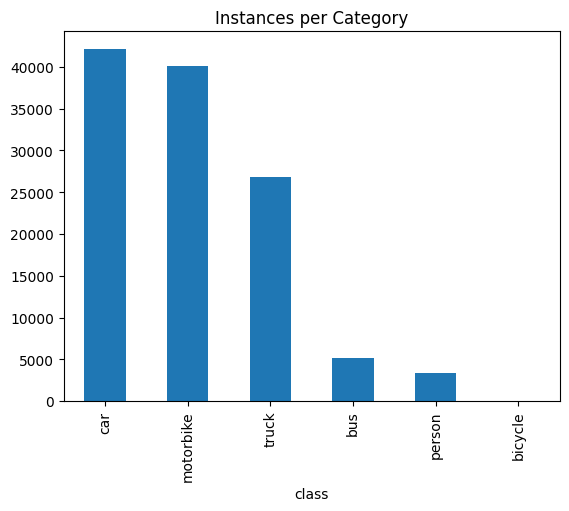

In [5]:
class_count = csv_data['class'].value_counts()
class_count.plot(kind='bar')
plt.title('Instances per Category')
plt.show()

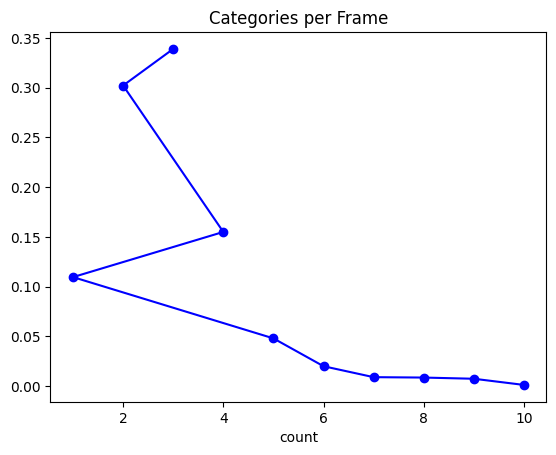

In [56]:
frame_count = csv_data.groupby(['frame'])['class'].agg(['count']).reset_index()
category_count = frame_count['count'].value_counts()
category_count = category_count / total_frames
category_count.plot(linestyle='-', marker='o', color='b')
plt.title("Categories per Frame")
plt.show()

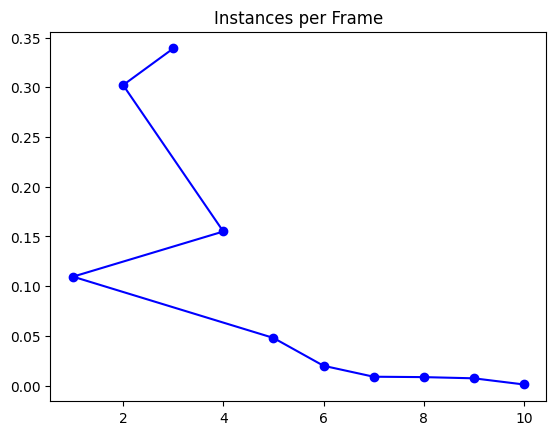

In [57]:
instance_count = csv_data.groupby('frame').size()
instance_count = instance_count.value_counts() / total_frames
instance_count.plot(linestyle='-', marker='o', color='b')
plt.title('Instances per Frame')
plt.show()

In [6]:
car_class = csv_data[csv_data['class'] == 'car'].copy().reset_index()
car_class

,index,frame,id,class,x,y,w,h,score
0,124,56,NaN,car,1225.11430,42.466644,56.611816,57.490517,0.105584
1,236,101,NaN,car,1210.46150,52.802162,60.230713,65.776760,0.237301
2,338,139,NaN,car,1197.22080,64.702490,67.107420,75.809320,0.142499
3,341,140,NaN,car,1195.50840,63.642952,68.570070,76.760185,0.425802
4,344,141,NaN,car,1196.23390,63.860207,69.210570,76.115730,0.244690
...,...,...,...,...,...,...,...,...,...
42125,117407,43162,NaN,car,542.16980,714.660030,286.765380,362.207640,0.197810
42126,117408,43163,NaN,car,548.41296,714.835900,280.438660,362.005920,0.182576
42127,117409,43164,NaN,car,548.03235,714.376830,280.613460,362.500120,0.134402
42128,117410,43165,NaN,car,547.94324,713.893430,280.690550,362.938480,0.141924


In [7]:
truck_class = csv_data[csv_data['class'] == 'truck'].copy().reset_index()
truck_class

,index,frame,id,class,x,y,w,h,score
0,0,0,NaN,truck,616.52700,206.33130,475.64246,635.03630,0.939772
1,2,1,NaN,truck,616.17090,204.28949,476.14673,637.02250,0.940433
2,4,2,NaN,truck,615.70386,207.02710,476.99390,633.96185,0.941185
3,7,3,NaN,truck,615.44100,206.87540,477.10540,633.92090,0.944163
4,9,4,NaN,truck,614.79170,208.17853,477.74628,632.52997,0.941668
...,...,...,...,...,...,...,...,...,...
26781,117264,42672,NaN,truck,628.13354,562.16986,289.62634,362.13520,0.276634
26782,117277,42684,NaN,truck,689.81824,577.62103,219.67969,371.46020,0.149295
26783,117282,42688,NaN,truck,667.36536,583.42800,239.21521,369.05792,0.120800
26784,117284,42689,NaN,truck,665.78040,584.28174,240.75922,369.32000,0.193304


In [8]:
motorbike_class = csv_data[csv_data['class'] == 'motorbike'].copy().reset_index()
motorbike_class

,index,frame,id,class,x,y,w,h,score
0,466,200,NaN,motorbike,1305.95260,84.31668,39.118410,77.448440,0.495583
1,469,201,NaN,motorbike,1306.03020,85.02747,38.955322,77.237785,0.460141
2,477,203,NaN,motorbike,1306.51860,87.13113,37.269653,77.695530,0.196920
3,481,204,NaN,motorbike,1306.58030,85.89015,37.474365,79.675520,0.757839
4,483,205,NaN,motorbike,1306.52500,86.00768,37.920776,80.064250,0.650041
...,...,...,...,...,...,...,...,...,...
40103,117533,44026,NaN,motorbike,783.94763,222.93214,53.909180,163.516830,0.297345
40104,117534,44027,NaN,motorbike,783.82930,223.10875,54.153810,161.433520,0.227650
40105,117535,44038,NaN,motorbike,783.82800,222.78745,53.526855,163.803130,0.220131
40106,117536,44039,NaN,motorbike,783.90546,222.86550,53.126953,165.071400,0.151035


In [9]:
bus_class = csv_data[csv_data['class'] == 'bus'].copy().reset_index()
bus_class

,index,frame,id,class,x,y,w,h,score
0,1,0,NaN,bus,1195.1466,137.63388,279.871220,400.577800,0.500422
1,3,1,NaN,bus,1194.4838,183.33485,280.650880,356.311650,0.482680
2,5,2,NaN,bus,1191.1436,139.56528,282.922360,404.543980,0.532109
3,6,2,NaN,bus,1190.8867,260.92722,283.497300,279.718960,0.167797
4,8,3,NaN,bus,1192.5878,142.61572,282.482180,401.405030,0.808703
...,...,...,...,...,...,...,...,...,...
5095,116696,42344,NaN,bus,1085.9636,139.98520,109.695070,110.777145,0.121434
5096,116699,42347,NaN,bus,1076.4573,140.16536,117.359860,111.088120,0.658428
5097,116703,42350,NaN,bus,1071.4170,140.63257,121.170654,114.863130,0.776631
5098,116705,42351,NaN,bus,1072.2740,144.53455,119.600220,110.645570,0.760549


In [10]:
bicycle_class = csv_data[csv_data['class'] == 'bicycle'].copy().reset_index()
bicycle_class

,index,frame,id,class,x,y,w,h,score
0,26038,9390,NaN,bicycle,878.93604,197.893800,37.406740,120.429016,0.118967
1,51113,15706,NaN,bicycle,1340.28930,779.351600,108.122560,300.307560,0.390600
2,51124,15707,NaN,bicycle,1359.96190,788.158800,80.891360,283.482800,0.217978
3,51134,15708,NaN,bicycle,1337.66500,795.683350,122.434326,283.584230,0.451797
4,51144,15709,NaN,bicycle,1338.71370,810.020300,115.149780,265.983830,0.267423
5,51175,15712,NaN,bicycle,1341.52480,838.338500,192.633910,240.226680,0.280276
6,51186,15713,NaN,bicycle,1343.09180,852.086200,197.473020,225.423340,0.125424
7,60556,17514,NaN,bicycle,1335.43530,102.879456,39.200684,89.358630,0.109782
8,60603,17549,NaN,bicycle,1340.96020,133.623870,42.080566,105.265780,0.265765
9,60607,17552,NaN,bicycle,1340.56590,135.114720,43.121582,106.777310,0.148940


In [11]:
person_class = csv_data[csv_data['class'] == 'person'].copy().reset_index()
person_class

,index,frame,id,class,x,y,w,h,score
0,3243,2229,NaN,person,707.96106,248.12837,58.677124,186.86736,0.430972
1,3248,2230,NaN,person,708.10130,247.68837,58.011840,186.96098,0.531833
2,3253,2231,NaN,person,706.07800,248.54608,59.257935,185.54489,0.394365
3,3256,2232,NaN,person,705.98706,247.54839,58.569885,185.67433,0.496137
4,3273,2235,NaN,person,701.17300,251.37776,60.064697,181.33223,0.115175
...,...,...,...,...,...,...,...,...,...
3391,117550,44127,NaN,person,739.48150,219.92615,61.446900,162.36713,0.520061
3392,117551,44128,NaN,person,739.00073,221.20702,61.852540,160.52590,0.122071
3393,117552,44130,NaN,person,739.75660,220.53731,60.952026,161.50670,0.336178
3394,117553,44131,NaN,person,740.50170,220.03473,60.285400,162.01190,0.236646


In [12]:
car_mean_score = car_class['score'].min()
car_mean_score

0.100051075

In [13]:
truck_mean_score = truck_class['score'].min()
truck_mean_score

0.100030124

In [14]:
motorbike_mean_score = motorbike_class['score'].min()
motorbike_mean_score

0.10000626

In [15]:
bus_mean_score = bus_class['score'].min()
bus_mean_score


0.10004472

In [16]:
bicycle_mean_score = bicycle_class['score'].min()
bicycle_mean_score


0.10764251

In [17]:
person_mean_score = person_class['score'].mean()
person_mean_score

0.39819134526325084

In [18]:
result = csv_data.groupby(['frame'])['score'].agg(['count', 'mean']).reset_index()
result

,frame,count,mean
0,0,2,0.720097
1,1,2,0.711557
2,2,3,0.547030
3,3,2,0.876433
4,4,2,0.841770
...,...,...,...
36740,44128,1,0.122071
36741,44130,1,0.336178
36742,44131,1,0.236646
36743,44181,1,0.156485


In [19]:
top_score = result.sort_values('mean', ascending=True).head(20)
top_score

,frame,count,mean
16921,17490,1,0.100051
6762,7121,1,0.100133
22403,25436,1,0.100163
6635,6983,1,0.100169
17981,19998,1,0.100277
5175,5449,1,0.100299
36568,43056,1,0.100335
20639,23191,1,0.100340
22411,25494,1,0.100358
31962,36241,1,0.100361


In [20]:
top_count = result.sort_values('count', ascending=False).head(10)
top_count

,frame,count,mean
15090,15616,14,0.650094
15029,15555,14,0.712170
14976,15502,14,0.625546
3007,3007,14,0.526920
14978,15504,14,0.495982
15033,15559,14,0.656022
15020,15546,14,0.664435
15019,15545,14,0.702702
15068,15594,14,0.510178
15038,15564,14,0.722696


In [22]:
object_data = result[result['mean'] < 0.7].copy()
object_data

,frame,count,mean
2,2,3,0.547030
5,5,2,0.650240
6,6,2,0.651896
11,11,2,0.686050
15,15,2,0.647084
...,...,...,...
36740,44128,1,0.122071
36741,44130,1,0.336178
36742,44131,1,0.236646
36743,44181,1,0.156485


In [23]:
object_count = object_data[object_data['count'] > 4].copy()
object_count

,frame,count,mean
201,201,5,0.503095
262,262,5,0.504348
345,345,5,0.517416
2230,2230,5,0.617388
2232,2232,5,0.499459
...,...,...,...
34913,40289,5,0.439020
34994,40370,5,0.548193
35959,42106,5,0.439473
35969,42116,5,0.557866


In [24]:
frame_list = object_count['frame'].to_list()
frame_list

[201,
 262,
 345,
 2230,
 2232,
 2233,
 2234,
 2235,
 2236,
 2256,
 2589,
 2808,
 2818,
 2819,
 2822,
 2824,
 2825,
 2827,
 2846,
 2847,
 2848,
 2849,
 2850,
 2852,
 2853,
 2854,
 2855,
 2857,
 2859,
 2868,
 2917,
 2919,
 2928,
 2929,
 2931,
 2932,
 2937,
 2938,
 2939,
 2940,
 2941,
 2942,
 2943,
 2944,
 2945,
 2946,
 2949,
 2951,
 2952,
 2953,
 2954,
 2955,
 2957,
 2958,
 2959,
 2961,
 2962,
 2964,
 2966,
 2968,
 2970,
 2974,
 2978,
 2981,
 2982,
 2999,
 3001,
 3003,
 3007,
 3008,
 3009,
 3010,
 3012,
 3013,
 3020,
 3026,
 3028,
 3033,
 3036,
 3037,
 3046,
 3095,
 3096,
 3103,
 3104,
 3105,
 3111,
 3112,
 3118,
 3119,
 3122,
 3123,
 3124,
 3125,
 3126,
 3129,
 3133,
 3134,
 3135,
 3136,
 3137,
 3138,
 3139,
 3140,
 3141,
 3142,
 3143,
 3144,
 3145,
 3150,
 3151,
 3152,
 3154,
 3169,
 3170,
 3171,
 3180,
 3182,
 3184,
 3188,
 3189,
 3190,
 3191,
 3194,
 3210,
 3211,
 3213,
 3214,
 3218,
 3219,
 3220,
 3222,
 3223,
 3230,
 3232,
 3234,
 3236,
 3237,
 3241,
 3242,
 3244,
 3254,
 3256,
 3

In [36]:
weights = 'D:/Data/models/yolov8/yolov8x_cf_v5.pt'
model = YOLO(weights)

In [37]:
video_source_path = "D:/Data/Piloto_RC_2024/C2_source.mp4"
cap = cv2.VideoCapture(video_source_path)
source_info = from_video_path(cap)

In [38]:
# Annotators
line_thickness = int(sv.calculate_optimal_line_thickness(resolution_wh=(source_info.width, source_info.height)) * 0.5)
text_scale = sv.calculate_optimal_text_scale(resolution_wh=(source_info.width, source_info.height)) * 0.5

label_annotator = sv.LabelAnnotator(text_scale=text_scale, text_padding=2, text_position=sv.Position.TOP_LEFT, text_thickness=line_thickness)
bounding_box_annotator = sv.BoundingBoxAnnotator(thickness=line_thickness)

In [39]:
frame_number = 0
while cap.isOpened():
    print(frame_number, end="", flush=True)
    success, image = cap.read()
    if frame_number in frame_list:
        annotated_image = image.copy()
        results = model(
            source=image,
            imgsz=640,
            conf=0.25,
            device='cuda' if torch.cuda.is_available() else 'cpu',
            verbose=False
        )[0]
        detections = sv.Detections.from_ultralytics(results)

        detections

        # Draw labels
        object_labels = [f"{data['class_name']} ({score:.2f})" for _, _, score, _, _, data in detections]
        annotated_image = label_annotator.annotate(
            scene=annotated_image,
            detections=detections,
            labels=object_labels )
        
        # Draw boxes
        annotated_image = bounding_box_annotator.annotate(
            scene=annotated_image,
            detections=detections )
        
        cv2.imshow("Output", annotated_image)
        cv2.waitKey(0)
        
    frame_number += 1

cv2.destroyAllWindows()
cap.release()




        
    

0123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899100101102103104105106107108109110111112113114115116117118119120121122123124125126127128129130131132133134135136137138139140141142143144145146147148149150151152153154155156157158159160161162163164165166167168169170171172173174175176177178179180181182183184185186187188189190191192193194195196197198199200201202203204205206207208209210211212213214215216217218219220221222223224225226227228229230231232233234235236237238239240241242243244245246247248249250251252253254255256257258259260261262263264265266267268269270271272273274275276277278279280281282283284285286287288289290291292293294295296297298299300301302303304305306307308309310311312313314315316317318319320321322323324325326327328329330331332333334335336337338339340341342343344345346347348

KeyboardInterrupt: 